## 1. Involved vs Informational - Count of Occurence Analysis

_Ekaterina Levitskaya, Kara Kedrick, and Russell J Funk. "Investigating  writing style as a contributor to gender gaps in science and technology”. In: arXiv (2022). doi: 10.48550/arxiv.2204.13805. eprint: 2204.13805._

Involved features: emphasizing relationships
- pronouns (personal, possessive, wh-pronoun)
- non-phrasal coordination ("and")
- questions

Informational features: emphasizing facts
- determiners (predeterminers, wh-determiers, determiners) --> no stop word removal!
- verbs in past tense
- cardinal numbers

involved rate: (n_pron+n_and+n_q)/N_tokens * 100
informational rate: (n_det+n_pas+n_num)/N_tokens * 100
inv-inf-ratio: involved rate / informational rate

Method:
- segmenting into sentences unsing SaT model (https://arxiv.org/abs/2406.16678) and wtsplit https://github.com/segment-any-text/wtpsplit
- detecting questions using

Concatenating all prompts from on user first, then computing scores.
Otherwise, if computing scores per individual prompt:

    - This approach treats each prompt as an _independent_ observation, but in reality, prompts from the same user are correlated (not independent).
    - The within-user variation gets mixed with between-user variation, increasing "noise" and inflating the standard error.
    - When you aggregate scores _after_ scoring, you're averaging numbers that are already affected by token count normalization and variance-stabilizing effects.
    - When performing statistical tests (like a t-test) at the prompt level, the repeated-measures structure (many prompts per user) is _ignored_, which "dilutes" between-group (gender) differences with within-group variation.
    - This makes it **harder to see a significant difference** — standard errors are larger than they should be, so statistical power is lower.


In [2]:
import sqlite3
import pandas as pd


from helpers.occurences import count_occurrences

conn = sqlite3.connect("../../giicg.db")

prompts = pd.read_sql("Select * from expanded_prompts", conn)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
749,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de
751,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


In [3]:
from helpers.normalization import remove_punctuation_and_newlines, remove_capitalization

prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)
prompts

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...",parsing data from python iterator how it could...,,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,write shortest tutorial on creating rag on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is faiss,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,transform given code to process large mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code i want to get nodes and edges ...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
749,1845,37,user,\n nun möchte ich judgement balancing m...,now i want to bring judgement balancing into t...,,,Woman (cisgender),29,de
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,i do not see any change in the plot,,,Woman (cisgender),29,de
751,1849,2,user,\n I am working on the problem of reconstru...,i am working on the problem of reconstruc...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


In [4]:
import spacy
import torch
import re
from wtpsplit import SaT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from helpers.occurences import count_occurrences


def load_spacy_lanuage_model() -> spacy.language.Language:
    try:
        return spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading missing model...")
        spacy.cli.download("en_core_web_sm")
        return spacy.load("en_core_web_sm")


def load_segmentation_model():
    return SaT("sat-3l-sm")


def load_question_detection_model():
    tokenizer = AutoTokenizer.from_pretrained("mrsinghania/asr-question-detection")
    model = AutoModelForSequenceClassification.from_pretrained("mrsinghania/asr-question-detection")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print("question model loaded")
    return tokenizer, model, device


def is_question(text: str, tokenizer, model, device) -> bool:
    if not isinstance(text, str) or text.strip() == "":
        return False
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    is_question = predicted_class == 1
    return is_question


def get_pronoun_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    pronouns = [token.text for token in doc if token.pos_ == "PRON"]
    print("prnouns:", pronouns)
    return len(pronouns)


def get_and_count(text: str) -> int:
    matches = re.findall(r'\band\b', text)
    count = len(matches)
    print("and count:", count)
    return count


def get_determiner_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.tag_ == "DT":  # Regular determiners (includes "the", "a", "my")
            count += 1
        elif token.tag_ == "PDT":  # Predeterminers (e.g., "all", "such")
            count += 1
        elif token.tag_ == "WDT":  # WH-determiners (e.g., "which", "whatever")
            count += 1
    print("determiner count:", count)
    return count


def get_verb_past_tense_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.lower_ == "could":
            continue  # Skip "could"
        if token.tag_ == "VBD" or token.tag_ == "VBN":
            count += 1
    print("verb past tense count:", count)
    return count


def get_number_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.pos_ == "NUM": count += 1
    print("number count:", count)
    return count


def get_question_count(text: str, tokenizer, model, device, sat) -> int:
    segmented = sat.split(text)
    count = 0
    for sentence in segmented:
        if is_question(sentence, tokenizer, model, device):
            count += 1
    print("question count:", count)
    return count


def compute_involved(text: str, tokenizer, model, device, sat, spacy_model) -> float:
    print("computing involved score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_pronoun = get_pronoun_count(text, spacy_model)
    print("n_pronoun:", n_pronoun)
    n_and = get_and_count(text)
    print("n_and:", n_and)
    n_question = get_question_count(text, tokenizer, model, device, sat)
    print("n_question:", n_question)
    score = ((n_pronoun + n_and + n_question) / len(tokens)) * 100
    print("involved score:", score)
    return score


def compute_informational(text: str, spacy_model) -> float:
    print("computing informational score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_determiner = get_determiner_count(text, spacy_model)
    n_verb_past_tense = get_verb_past_tense_count(text, spacy_model)
    n_number = get_number_count(text, spacy_model)
    score = ((n_determiner + n_verb_past_tense + n_number) / len(tokens)) * 100
    print("informational score:", score)
    return score


def compute_inv_inf_ratio(inv: float, inf: float) -> float:
    if inf == 0:
        return inv
    return inv / inf

tokenizer, question_model, device = load_question_detection_model()
spacy_model = load_spacy_lanuage_model()
sat = load_segmentation_model()

def compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model):
    prompts['n_tokens'] = prompts['conversational'].apply(lambda x: len(x.split()))

    prompts['n_det'] = prompts.apply(lambda row: (get_determiner_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_past_tense'] = prompts.apply(lambda row: (get_verb_past_tense_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_numbers'] = prompts.apply(lambda row: (get_number_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_pronouns'] = prompts.apply(lambda row: (get_pronoun_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_and'] = prompts.apply(lambda row: (count_occurrences(row['conversational'], "and", True)/row['n_tokens'])*100, axis=1)
    prompts['n_questions'] = prompts.apply(lambda row: (get_question_count(row['conversational'], tokenizer, question_model, device, sat)/row['n_tokens'])*100, axis=1)

    prompts['involved'] = prompts.apply(lambda row: (row['n_pronouns'] + row['n_and'] + row['n_questions']), axis=1)
    prompts['informational'] = prompts.apply(lambda row: (row['n_det'] + row['n_past_tense'] + row['n_numbers']), axis=1)
    prompts['inv_inf'] = prompts.apply(lambda row: compute_inv_inf_ratio(row['involved'], row['informational']) , axis=1)

    return prompts



question model loaded


In [5]:
scores = compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model)
scores

determiner count: 0
determiner count: 12
determiner count: 0
determiner count: 0
determiner count: 0
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 1
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 4
determiner count: 2
determiner count: 3
determiner count: 2
determiner count: 3
determiner count: 1
determiner count: 4
determiner count: 1
determiner count: 0
determiner count: 3
determiner count: 2
determiner count: 4
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 7
determiner count: 4
determiner count: 8
determiner count: 8
determiner count: 2
determiner count: 1
determiner count: 2
determiner count: 2
determiner count: 1
determiner count: 10
determiner count: 1
determiner count: 1
determiner count: 1
determiner count: 2
determiner count: 4
determiner count: 3
determiner count: 1
determiner count: 3
determiner count: 2
determiner count: 0
determiner count: 2
determiner count: 3
determiner count: 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


question count: 0
question count: 0
question count: 0
question count: 1
question count: 0
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 0
question count: 0
question count: 0
question count: 1
question count: 1
question count: 0
question count: 1
question count: 0
question count: 0
question count: 0
question count: 2
question count: 1
question count: 0
question count: 0
question count: 0
question count: 0
question count: 0
question count: 1
question count: 0
question count: 0
question count: 1
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 1
question c

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language,n_tokens,n_det,n_past_tense,n_numbers,n_pronouns,n_and,n_questions,involved,informational,inv_inf
0,1,1,user,"parsing data from python iterator, how it coul...",parsing data from python iterator how it could...,,,Man (cisgender),6,en,17,0.000000,5.882353,0.000000,11.764706,0.000000,0.000000,11.764706,5.882353,2.000000
1,730,32,user,Write python function to do operations with in...,write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en,109,11.009174,4.587156,4.587156,9.174312,0.000000,0.000000,9.174312,20.183486,0.454545
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,write shortest tutorial on creating rag on ema...,,,Man (cisgender),6,en,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1135,55,user,what is FAISS,what is faiss,,,Man (cisgender),6,en,3,0.000000,0.000000,0.000000,33.333333,0.000000,33.333333,66.666667,0.000000,66.666667
4,1137,55,user,Transform given code to process large .mbox file,transform given code to process large mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en,8,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,12.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code i want to get nodes and edges ...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en,51,15.686275,1.960784,0.000000,13.725490,1.960784,0.000000,15.686275,17.647059,0.888889
749,1845,37,user,\n nun möchte ich judgement balancing m...,now i want to bring judgement balancing into t...,,,Woman (cisgender),29,de,51,13.725490,3.921569,1.960784,1.960784,7.843137,0.000000,9.803922,19.607843,0.500000
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,i do not see any change in the plot,,,Woman (cisgender),29,de,9,22.222222,0.000000,0.000000,11.111111,0.000000,0.000000,11.111111,22.222222,0.500000
751,1849,2,user,\n I am working on the problem of reconstru...,i am working on the problem of reconstruc...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en,23,13.043478,0.000000,0.000000,8.695652,0.000000,0.000000,8.695652,13.043478,0.666667


In [7]:
scores.to_sql("inv_inf_scores", conn,if_exists="replace", index=False)

753

In [7]:
def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs= []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    for col in columns:
        result = compare_genders(df, col, one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['m_female'])
        male_means.append(result['m_male'])
        female_stds.append(result['std_female'])
        male_stds.append(result['std_male'])
        n_females.append(result['n_female'])
        n_males.append(result['n_male'])
        nonzero_females.append(result['hits_female'])
        nonzero_males.append(result['hits_male']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
    })
    return results

# Group per user

In [4]:
prompts = compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model)

filtered= prompts[prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]
columns = ['involved', 'informational', 'inv_inf', 'n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions']
user_means = (
    filtered.groupby(['user_id', 'gender'])[columns].mean().reset_index()
)
user_means

determiner count: 0
determiner count: 12
determiner count: 0
determiner count: 0
determiner count: 0
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 1
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 4
determiner count: 2
determiner count: 3
determiner count: 2
determiner count: 3
determiner count: 1
determiner count: 4
determiner count: 1
determiner count: 0
determiner count: 3
determiner count: 2
determiner count: 4
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 7
determiner count: 4
determiner count: 8
determiner count: 8
determiner count: 2
determiner count: 1
determiner count: 2
determiner count: 2
determiner count: 1
determiner count: 10
determiner count: 1
determiner count: 1
determiner count: 1
determiner count: 2
determiner count: 4
determiner count: 3
determiner count: 1
determiner count: 3
determiner count: 2
determiner count: 0
determiner count: 2
determiner count: 3
determiner count: 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


question count: 0
question count: 0
question count: 0
question count: 1
question count: 0
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 0
question count: 0
question count: 0
question count: 1
question count: 1
question count: 0
question count: 1
question count: 0
question count: 0
question count: 0
question count: 2
question count: 1
question count: 0
question count: 0
question count: 0
question count: 0
question count: 0
question count: 1
question count: 0
question count: 0
question count: 1
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 1
question count: 1
question count: 0
question count: 1
question count: 1
question count: 1
question c

,user_id,gender,involved,informational,inv_inf,n_det,n_past_tense,n_numbers,n_pronouns,n_and,n_questions
0,6,Man (cisgender),20.590146,11.742204,8.531987,8.680352,2.552168,0.509684,11.943360,0.617284,8.029501
1,8,Man (cisgender),8.193980,18.060201,0.500000,14.214047,0.000000,3.846154,8.193980,0.000000,0.000000
2,11,Woman (cisgender),21.382256,19.278544,1.317100,15.102779,1.549103,2.626662,14.699151,0.570248,6.112857
3,15,Man (cisgender),15.664488,13.921569,4.203704,13.921569,0.000000,0.000000,15.664488,0.000000,0.000000
4,16,Woman (cisgender),15.110395,16.448038,0.921974,13.557609,1.533469,1.356959,10.717149,1.319450,3.073796
5,25,Man (cisgender),14.791667,15.625000,0.950000,14.301471,1.323529,0.000000,7.058824,2.303922,5.428922
6,28,Woman (cisgender),18.801711,18.568637,1.099297,16.080422,2.025163,0.463052,14.888285,2.045935,1.867491
7,29,Woman (cisgender),10.457516,20.915033,0.500000,17.973856,1.960784,0.980392,6.535948,3.921569,0.000000
8,31,Man (cisgender),20.060606,24.636364,0.861111,16.727273,7.353535,0.555556,10.686869,0.909091,8.464646
9,34,Man (cisgender),13.577383,19.063797,3.777699,13.992177,3.487476,1.584144,9.528281,1.342268,2.706835


## Concatenate per user first

determiner count: 19
determiner count: 5
determiner count: 25
determiner count: 5
determiner count: 75
determiner count: 15
determiner count: 90
determiner count: 9
determiner count: 15
determiner count: 195
determiner count: 11
determiner count: 132
determiner count: 26
determiner count: 91
determiner count: 14
determiner count: 10
determiner count: 4
determiner count: 10
determiner count: 394
determiner count: 55
determiner count: 104
determiner count: 25
determiner count: 43
determiner count: 8
determiner count: 51
determiner count: 24
determiner count: 167
determiner count: 22
verb past tense count: 7
verb past tense count: 0
verb past tense count: 3
verb past tense count: 0
verb past tense count: 12
verb past tense count: 2
verb past tense count: 13
verb past tense count: 2
verb past tense count: 5
verb past tense count: 41
verb past tense count: 4
verb past tense count: 27
verb past tense count: 0
verb past tense count: 27
verb past tense count: 5
verb past tense count: 0
verb pa

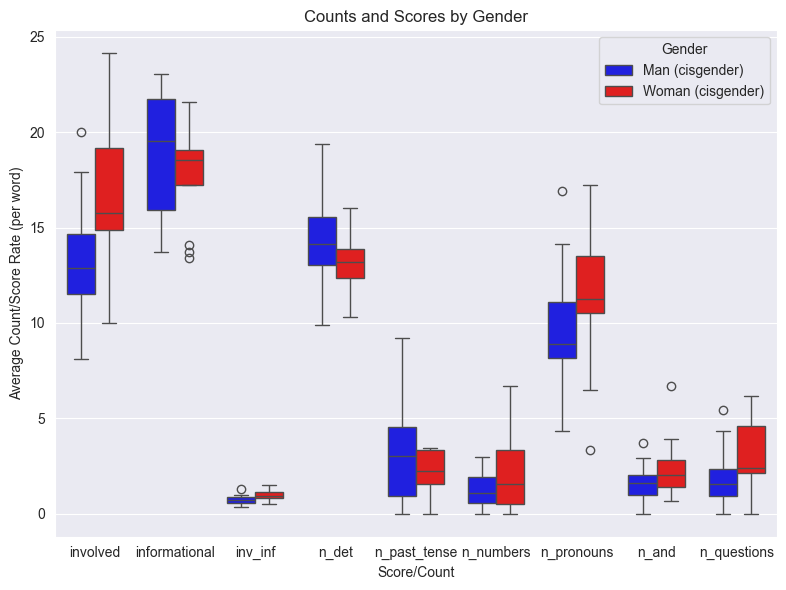

In [5]:
from helpers.statistical_tests import run_t_test_on_gender, compare_genders
import matplotlib.pyplot as plt
import seaborn as sns

user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()
)

user_prompts= user_prompts[user_prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_prompts = compute_scores(user_prompts, tokenizer, question_model, device, sat, spacy_model)

columns = ['involved', 'informational', 'inv_inf', 'n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions']

melted = user_prompts.melt(
    id_vars=['user_id', 'gender'],
    value_vars=columns,
    var_name='Score/Count',
    value_name='Normalized Rate'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Score/Count',
    y='Normalized Rate',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Counts and Scores by Gender')
plt.ylabel('Average Count/Score Rate (per word)')
plt.xlabel('Score/Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()




## Statistical Tests

In [18]:
from helpers.make_latex_table import create_latex_table_from_stats
results = groupwise_comparison_with_correction(user_prompts, ['inv_inf'], one_sided=True, direction="smaller")
results = results.sort_values(by="p_value", ascending=True)
create_latex_table_from_stats(results, "inf_inv_results")
results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,inv_inf,T-test,smaller,True,22.384083,-2.376051,0.013232,0.013232,0.979821,0.734303,0.303107,0.232699,13,15,13,15,-0.917798,Cohen's d


In [15]:
all_results = groupwise_comparison_with_correction(user_prompts, ['involved', 'informational'], one_sided=False)
all_results = all_results.sort_values(by="p_value", ascending=True)
all_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,involved,T-test,two-sided,False,23.596821,-2.530255,0.018500,0.037001,16.761776,13.283527,3.904672,3.279242,13,15,13,15,-0.971171,Cohen's d
1,informational,Mann-Whitney U,greater,False,NaN,119.000000,0.333358,0.333358,17.650713,18.722569,2.531043,3.495770,13,15,13,15,0.220513,RBC


In [16]:
detailed_results = groupwise_comparison_with_correction(user_prompts, ['n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions'], one_sided=False)
detailed_results = detailed_results.sort_values(by="p_value", ascending=True)
detailed_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
5,n_questions,T-test,two-sided,False,24.797088,-1.947733,0.062854,0.338681,3.049098,1.845114,1.684647,1.567453,13,15,12,12,-0.742011,Cohen's d
4,n_and,Mann-Whitney U,greater,False,NaN,65.000000,0.140348,0.338681,2.415731,1.572896,1.570989,1.019704,13,15,13,13,-0.333333,RBC
0,n_det,T-test,two-sided,False,24.764689,1.415622,0.169340,0.338681,13.320852,14.450107,1.702054,2.490468,13,15,13,15,0.522175,Cohen's d
3,n_pronouns,T-test,two-sided,False,23.461288,-1.060886,0.299541,0.426605,11.296947,9.865517,3.847655,3.197848,13,15,13,15,-0.407498,Cohen's d
2,n_numbers,Mann-Whitney U,greater,False,NaN,77.000000,0.355504,0.426605,2.302105,1.283929,2.304416,1.003373,13,15,11,12,-0.210256,RBC
1,n_past_tense,Mann-Whitney U,greater,False,NaN,112.500000,0.502053,0.502053,2.027756,2.988534,1.305635,2.625305,13,15,10,12,0.153846,RBC


In [21]:
combined = pd.concat([results, all_results], axis=0)
create_latex_table_from_stats(combined, "inv_inf_combined_results")
combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type
0,inv_inf,T-test,smaller,True,22.384083,-2.376051,0.013232,0.013232,0.979821,0.734303,0.303107,0.232699,13,15,13,15,-0.917798,Cohen's d
0,involved,T-test,two-sided,False,23.596821,-2.530255,0.018500,0.037001,16.761776,13.283527,3.904672,3.279242,13,15,13,15,-0.971171,Cohen's d
1,informational,Mann-Whitney U,greater,False,NaN,119.000000,0.333358,0.333358,17.650713,18.722569,2.531043,3.495770,13,15,13,15,0.220513,RBC
